In [1]:
#impost libraries
import pandas as pd
import scipy
import numpy as np

%matplotlib inline

In [2]:
# read in the CSV's
calls = pd.read_csv(r'../data/callsForServiceUpdated.csv')

C:\Users\81wingo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Clean up


In [3]:
calls = calls[calls.rptonly != True]
calls = calls[calls.cancelled != True]
print(len(calls))

1085198


In [4]:
calls['calltime'] = pd.to_datetime(calls.calltime)
calls['year'] = calls.calltime.apply(lambda x: x.date().year)
calls['month'] = calls.calltime.apply(lambda x: x.date().month)
calls['dayOfMonth'] = calls.calltime.apply(lambda x: x.date().day)
calls['hour'] = calls.calltime.apply(lambda x: x.time().hour)
calls = calls.rename(columns={'calldow' : 'dayOfWeek'})
calls = calls.drop(columns = ['timeclose', 'calltime'], axis = 1)
calls

,inci_id,parent_id,case_id,callsource,street,city,streetonly,geox,geoy,nature,...,secsar2lc,secsrt2dsp,secstr2lc,firstdisp,long,lat,year,month,dayOfMonth,hour
0,2012324665,NaN,NaN,SELF,OLD RANDLEMAN RD/COLTRANE MILL RD,G,OLD RANDLEMAN RD/COLTRANE MILL RD,1755293.88,800660.13,TRAFFIC STOP,...,651,0,0,S335,-79.826738,35.947098,2012,7,1,0
1,2012324676,NaN,1234238.0,E911,312 MARTIN LUTHER KING JR DR,G,MARTIN LUTHER KING JR DR,1767127.13,843918.75,HEMORRHAGE / LACERATIONS,...,2454,43,965,M261,-79.787921,36.066193,2012,7,1,0
2,2012324686,NaN,NaN,SELF,4525 W WENDOVER AV,G,W WENDOVER AV,1731815.63,838827.63,TRANSPORT TO ANIMAL SHELTER,...,0,0,0,ACO8,-79.907233,36.051380,2012,7,1,0
3,2012324690,NaN,1234239.0,E911,3905 BROOKHOLLOW RD,W,BROOKHOLLOW RD,1808054.75,822506.31,SEIZURES-CONVULSIONS,...,4522,30,3918,M2,-79.648974,36.008188,2012,7,1,0
4,2012324692,2.012325e+09,1206134.0,E911,3905 BROOKHOLLOW RD,W,BROOKHOLLOW RD,1808054.75,822506.31,SEIZURES-CONVULSIONS,...,900,8,0,E44,-79.648974,36.008188,2012,7,1,0
5,2012324697,NaN,1234240.0,E911,5125 MICHAUX RD,G,MICHAUX RD,1744080.88,874458.88,FALLS-BACK INJURIES(TRAUMATIC),...,0,10,0,M241,-79.866796,36.149555,2012,7,1,0
6,2012324704,NaN,1234241.0,E911,1409 DANS RD,G,DANS RD,1778039.38,840417.56,SICK PERSON,...,2295,29,1267,M211,-79.750911,36.056808,2012,7,1,0
7,2012324709,NaN,NaN,SELF,8069 HAW RIVER RD,ST,HAW RIVER RD,1709461.00,897647.69,TRAFFIC STOP,...,112,0,0,S314,-79.984825,36.212362,2012,7,1,0
8,2012324711,NaN,1234242.0,W911,WESTCHESTER DR/N MAIN ST,H,WESTCHESTER DR/N MAIN ST,1697332.38,814158.75,CHEST PAIN,...,2090,17,1323,M221,-80.023017,35.982696,2012,7,1,0
9,2012324715,NaN,NaN,PHONE,8403 MEARS FORK RD,SU,MEARS FORK RD,1759324.13,906703.25,DOMESTIC DISPUTE,...,1109,102,0,S314,-79.816067,36.238478,2012,7,1,0


Drop unnecessary Columns

In [5]:
calls['actualnature'] = [x['nature2'] if x['nature'] is np.nan and x['nature'] != x['nature2'] else x['nature'] for i,x in calls.iterrows()]

In [6]:
calls.columns


Index(['inci_id', 'parent_id', 'case_id', 'callsource', 'street', 'city',
       'streetonly', 'geox', 'geoy', 'nature', 'nature2', 'priority',
       'medprior', 'meddislvl', 'rptonly', 'service', 'agency', 'district',
       'statbeat', 'ra', 'gp', 'primeunit', 'cancelled', 'closecode',
       'dayOfWeek', 'secs2rt', 'secs2di', 'secs2en', 'secs2ar', 'secs2tr',
       'secs2lc', 'secsdi2en', 'secsdi2ar', 'secsar2tr', 'secsar2lc',
       'secsrt2dsp', 'secstr2lc', 'firstdisp', 'long', 'lat', 'year', 'month',
       'dayOfMonth', 'hour', 'actualnature'],
      dtype='object')

In [7]:
calls.shape

(1085198, 45)

In [8]:
calls.priority.unique()

array(['1', '4', '9', 'P', '3', '2', '7', '5', '8', nan, '6'],
      dtype=object)

There are nan in the set so we need to get rid of those

In [9]:
calls = calls[calls['priority'].notnull()]

In [10]:
#make sure that the nan values are gone
calls.priority.unique()

array(['1', '4', '9', 'P', '3', '2', '7', '5', '8', '6'], dtype=object)

In [11]:
newdf = calls.drop(columns=['inci_id', 'parent_id', 'case_id', 'callsource', 'street', 'city',
       'streetonly', 'geox', 'geoy', 'nature', 'nature2', 'medprior', 'meddislvl', 'rptonly', 'service', 
       'statbeat', 'ra', 'gp', 'primeunit', 'cancelled', 'closecode',
       'dayOfWeek', 'secs2rt', 'secs2di', 'secs2en', 'secs2tr',
       'secs2lc', 'secsdi2en', 'secsdi2ar', 'secsar2tr', 'secsar2lc',
       'secsrt2dsp', 'secstr2lc', 'firstdisp', 'long', 'lat', 'year', 'month',
       'dayOfMonth', 'hour'])

In [12]:
#use sklearn label encoder to convert strings to numbers that can be used for calculations
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
for col in newdf.columns:
    newdf[col] = labelencoder.fit_transform(newdf[col].astype(str))
 
newdf.head(11)

,priority,agency,district,secs2ar,actualnature
0,0,3,58,0,192
1,3,1,13,9397,126
2,8,0,63,0,198
3,0,1,11,14047,173
4,9,2,0,11299,173
5,2,1,9,0,103
6,3,1,4,5985,174
7,0,3,55,1,192
8,0,1,5,6447,70
9,0,3,55,1048,86


In [13]:
newdf.columns


Index(['priority', 'agency', 'district', 'secs2ar', 'actualnature'], dtype='object')

In [14]:
newdf.describe()

,priority,agency,district,secs2ar,actualnature
count,1.084954e+06,1.084954e+06,1.084954e+06,1.084954e+06,1.084954e+06
mean,2.708889e+00,1.797061e+00,3.197515e+01,5.612920e+03,1.239234e+02
std,2.954226e+00,1.072626e+00,2.335326e+01,4.546270e+03,6.978734e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,1.000000e+00,7.000000e+00,1.000000e+00,6.100000e+01
50%,1.000000e+00,1.000000e+00,3.400000e+01,6.061000e+03,1.240000e+02
75%,4.000000e+00,3.000000e+00,5.700000e+01,8.979000e+03,1.920000e+02
max,9.000000e+00,3.000000e+00,6.300000e+01,1.482100e+04,2.570000e+02


In [15]:
newdf['priority'].value_counts()

0    302044
1    253865
3    130006
2    103999
6    100373
8     78146
9     78126
4     37366
7       995
5        34
Name: priority, dtype: int64

In [16]:
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)

In [17]:
import statsmodels.formula.api as smf
fitdf= smf.ols(formula = 'priority ~ district + agency + actualnature + secs2ar', data= newdf).fit()
fitdf.params

Intercept       4.706027
district        0.069916
agency         -1.515121
actualnature   -0.009563
secs2ar        -0.000058
dtype: float64

In [18]:
fitdf.rsquared

0.2597738239698696

In [19]:
fitdf.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               priority   R-squared:                       0.260
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                 9.519e+04
Date:                Fri, 30 Nov 2018   Prob (F-statistic):               0.00
Time:                        05:46:11   Log-Likelihood:            -2.5516e+06
No. Observations:             1084954   AIC:                         5.103e+06
Df Residuals:                 1084949   BIC:                         5.103e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        4.7060      0.009    503.754      0.000       4.688       4.724
district         0.0699      0.000    541.003      0.000       0.070       0.070
agency          -1.5151      0.003   -518.615      0.000      -1.521      -1.509
actualnature    -0.0096   3.86e-05   -247.562      0.000      -0.010      -0.009
secs2ar      -5.787e-05   5.98e-07    -96.817      0.000    -5.9e-05   -5.67e-05
==============================================================================
Omnibus:                   111111.117   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           148457.362
Skew:                           0.872   Prob(JB):                         0.00
Kurtosis:                       3.494   Cond. No.                     2.83e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.83e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [20]:
fitdf.corr()

,priority,agency,district,secs2ar,actualnature
priority,1.000000,-0.202593,0.266560,-0.037335,0.010292
agency,-0.202593,1.000000,0.484994,-0.391401,-0.197476
district,0.266560,0.484994,1.000000,-0.332252,0.216524
secs2ar,-0.037335,-0.391401,-0.332252,1.000000,-0.088710
actualnature,0.010292,-0.197476,0.216524,-0.088710,1.000000


In [21]:
newdf.head()

,priority,agency,district,secs2ar,actualnature
0,0,3,58,0,192
1,3,1,13,9397,126
2,8,0,63,0,198
3,0,1,11,14047,173
4,9,2,0,11299,173


from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
X = newdf.iloc[:,1:4]
y = newdf.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
scaler = preprocessing.StandardScaler()
X_train=scaler.fit_transform(X_train)

regression_model = LinearRegression()
regression_model.fit(X_train, y_train)
regression_model.score(X_train, y_train)

**R squared value said that this would not be an accurate, but i wanted a starting point of how good a "bad" model would be**

In [85]:
from sklearn.model_selection import train_test_split
X = newdf
y= newdf.priority


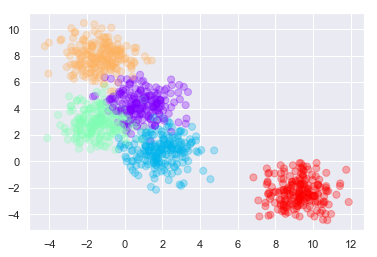

In [107]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=1000, centers=5, n_features=2,
                  random_state=0)
ax= plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='rainbow', alpha = .3);


In [104]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=5)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # fit the estimator
    model.fit(X, y)
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)

In [98]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [24]:
from sklearn.neighbors import KNeighborsClassifier
for n_neighbors in [5, 10, 15, 20]:
# create the model
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)

# fit the model
    y_pred_knn=knn.fit(X_train, y_train)
#print each group out 
    print(n_neighbors, knn.score(X_test, y_test))

5 0.8191940077483894
10 0.7761016569018118
15 0.7511452070282377
20 0.7315253758214614


It looks like a lower K Neighbor will be more likely to be accurate. So lets try a group of numbers less than 5.

In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
for n_neighbors in [2, 3, 4, 5]:
# create the model
    knn = KNeighborsClassifier(n_neighbors=n_neighbors)

# fit the model
    y_pred_knn=knn.fit(X_train, y_train)
#print each group out 
    print(n_neighbors, knn.score(X_test, y_test))

2 0.8549896001990863
3 0.8465099988632419
4 0.8305953847619106
5 0.8191940077483894


## K-fold Cross Validation


In [26]:
from sklearn.cross_validation import cross_val_score
cv = cross_val_score(KNeighborsClassifier(2), X, y, cv=10)
print(cv)

C:\Users\81wingo\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


[0.87326267 0.87688479 0.87741935 0.87939981 0.87748048 0.8789253
 0.8748652  0.87454259 0.86991548 0.84354318]


C:\Users\81wingo\Anaconda3\lib\site-packages\matplotlib\contour.py:1004: UserWarning: The following kwargs were not used by contour: 'clim'
  s)


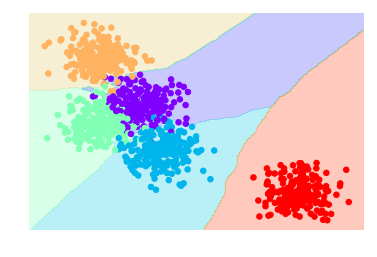

In [108]:
visualize_classifier(KNeighborsClassifier(), X, y)

In [27]:
cv.mean()

0.8726238855381881

## PCA Dimensional reduction

In [99]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X_train)
X_reduced = pca.transform(X)
prediction =pca.score(X_test,y_test)
print(prediction)

-5.044618435795034


## SVM

from sklearn import svm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

X = newdf.iloc[:,1:4]
y = newdf.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
scaler = preprocessing.StandardScaler()
X_train=scaler.fit_transform(X_train)

clf = svm.SVC()
clf.fit(X_train, y_train)

X_test=scaler.fit_transform(X_test)
y_predict=clf.predict(X_test)

from sklearn.metrics import accuracy_score
score=accuracy_score(y_test,y_predict)
print(score)

**..... ran two days so lets try taking a random sample and seeing how the accuracy is**

In [29]:
sample = newdf.sample(n=100, replace = False)

In [31]:
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X = sample.iloc[:,1:4]
y = sample.iloc[:,0]

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

scaler = preprocessing.StandardScaler() 
X_train=scaler.fit_transform(X_train)

from sklearn.svm import SVC # "Support Vector Classifier"
clf = SVC(kernel='linear')
clf.fit(X, y)
 
y_predict=clf.predict(X_test)

 
score=accuracy_score(y_test,y_predict) 
print(score)

0.3466666666666667


The Sample size is so small because when I increased the sample size to 1000 it ran over night and still was unable to finish. With more computing power and time a SVC would be possible.

## Random Forest Classifier

In [112]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# use seaborn plotting defaults
import seaborn as sns; sns.set()
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### Decision Tree

In [113]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X_train, y_train)


C:\Users\81wingo\Anaconda3\lib\site-packages\matplotlib\contour.py:1004: UserWarning: The following kwargs were not used by contour: 'clim'
  s)


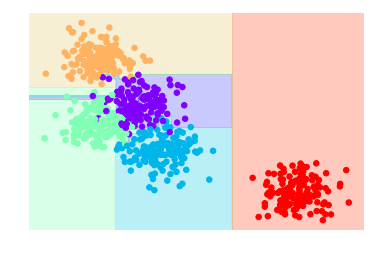

In [114]:
visualize_classifier(DecisionTreeClassifier(), X_train, y_train)

In [115]:
tree.score(X,y,sample_weight=None)

0.981

C:\Users\81wingo\Anaconda3\lib\site-packages\matplotlib\contour.py:1004: UserWarning: The following kwargs were not used by contour: 'clim'
  s)


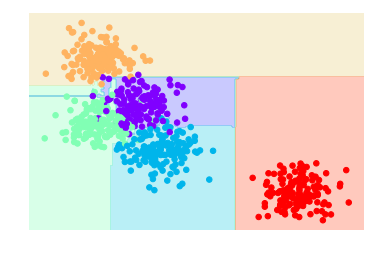

In [121]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=10)
y_pred = RandomForestClassifier().fit(X_train, y_train)
visualize_classifier(clf, X_train, y_train);

In [122]:
clf.score(X_train, y_train,sample_weight=None)

0.9971428571428571